
# UI Handler Demo (progressive complexity)

Run cells top-to-bottom. Uses the existing UI handler to inspect view state, events, and frontends.


In [1]:
from pprint import pprint
from pathlib import Path
import json

from hypernodes import Pipeline, node
from hypernodes.viz.ui_handler import UIHandler
from hypernodes.viz.js_ui import (
    generate_widget_html,
    transform_to_react_flow,
)
from IPython.display import HTML


In [2]:
# Base nodes
@node(output_name="text_step")
def add_bang(text: str) -> str:
    return text + "!"


@node(output_name="upper_text")
def to_upper(text_step: str) -> str:
    return text_step.upper()


@node(output_name="clean")
def clean_text(raw_text: str, suffix: str = "", language: str = "en") -> str:
    return f"{language}:{raw_text.strip()}{suffix}"


@node(output_name="length")
def text_length(clean: str) -> int:
    return len(clean)


@node(output_name="preview")
def text_preview(clean: str) -> str:
    return clean[:8]


@node(output_name="score")
def score(inner_length: int, tag: str, bias: int = 0) -> str:
    return f"{tag}:{inner_length + bias}"


In [3]:
def build_inner_pipeline():
    return Pipeline(
        nodes=[clean_text, text_length, text_preview],
        name="InnerPipeline",
    ).bind(suffix="*", language="en")


def build_outer_pipeline():
    inner = build_inner_pipeline()
    inner_node = inner.as_node(
        name="InnerPipeline",
        input_mapping={"text_step": "raw_text"},
        output_mapping={
            "length": "inner_length",  # used by score
            "preview": "inner_preview",  # unused downstream
        },
    )

    outer = Pipeline(
        nodes=[
            add_bang,
            inner_node,
            score,
        ],
        name="OuterPipeline",
    ).bind(bias=2)  # outer bound input

    return outer


outer = build_outer_pipeline()
outer


Pipeline(name='OuterPipeline', nodes=3, bound=[bias=2], needs=[tag, text])

In [4]:
# Check what inputs are rendered in the visualization
from hypernodes.viz.ui_handler import UIHandler

handler = UIHandler(outer, depth=1)
view = handler.get_view_data()

print("=== Rendered nodes (depth=1) ===")
render_nodes = view.get("render_nodes", [])
for n in render_nodes:
    node_type = n.get("node_type")
    if node_type in ["INPUT", "INPUT_GROUP"]:
        print(
            f"  {n['label']:30} type={node_type:15} is_bound={n.get('is_bound', False)}"
        )

=== Rendered nodes (depth=1) ===
  text : str                     type=INPUT           is_bound=False
  tag : str                      type=INPUT           is_bound=False
  bias : int                     type=INPUT           is_bound=True


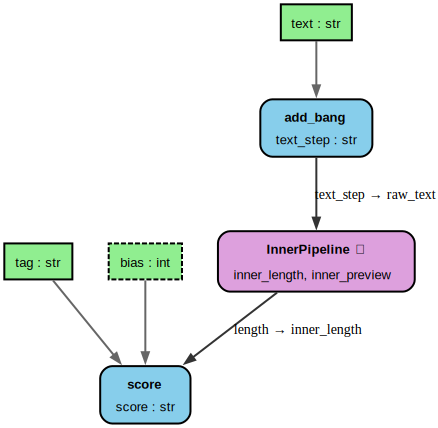

In [5]:
outer.visualize(depth=1, interactive=False)

In [6]:
# Debug depth=1 vs depth=2
from hypernodes.viz.ui_handler import UIHandler

handler_d1 = UIHandler(outer, depth=1)
handler_d2 = UIHandler(outer, depth=2)

view_d1 = handler_d1.get_view_data()
view_d2 = handler_d2.get_view_data()

print("=== DEPTH=1 ===")
print(f"Nodes: {len(view_d1['nodes'])}")
for n in view_d1["nodes"]:
    print(
        f"  {n['label']:20} type={n['node_type']:10} root_args={n.get('root_args', [])} outputs={n.get('output_name') or n.get('output_names')}"
    )

print("\nEdges:")
for e in view_d1["edges"]:
    print(f"  {e['source']} -> {e['target']} (label: {e.get('label', '')})")

print("\n=== DEPTH=2 ===")
print(f"Nodes: {len(view_d2['nodes'])}")
for n in view_d2["nodes"]:
    print(
        f"  {n['label']:20} type={n['node_type']:10} root_args={n.get('root_args', [])} outputs={n.get('output_name') or n.get('output_names')}"
    )

print("\nEdges:")
for e in view_d2["edges"]:
    print(f"  {e['source']} -> {e['target']} (label: {e.get('label', '')})")

=== DEPTH=1 ===
Nodes: 3
  add_bang             type=STANDARD   root_args=['text'] outputs=text_step
  InnerPipeline        type=PIPELINE   root_args=['text_step'] outputs=['inner_length', 'inner_preview']
  score                type=STANDARD   root_args=['inner_length', 'tag', 'bias'] outputs=score

Edges:
  4532269376 -> 4533657552 (label: )
  input_text -> 4532269376 (label: )
  4533657552 -> 4533657024 (label: )
  input_tag -> 4533657024 (label: )
  input_bias -> 4533657024 (label: )

=== DEPTH=2 ===
Nodes: 6
  add_bang             type=STANDARD   root_args=['text'] outputs=text_step
  InnerPipeline        type=PIPELINE   root_args=['text_step'] outputs=['inner_length', 'inner_preview']
  clean_text           type=STANDARD   root_args=['raw_text', 'suffix', 'language'] outputs=clean
  text_length          type=STANDARD   root_args=['clean'] outputs=length
  text_preview         type=STANDARD   root_args=['clean'] outputs=preview
  score                type=STANDARD   root_args=['in

In [7]:
# Let's check the inner pipeline's root_args
inner = build_inner_pipeline()
print("Inner pipeline root_args:", inner.graph.root_args)
print("Inner pipeline bound_inputs:", inner.bound_inputs)
print("Inner pipeline unfulfilled_args:", inner.unfulfilled_args)

inner_node = inner.as_node(
    name="InnerPipeline",
    input_mapping={"text_step": "raw_text"},
    output_mapping={
        "length": "inner_length",
        "preview": "inner_preview",
    },
)

print("\nInner node root_args:", inner_node.root_args)
print("Inner node unfulfilled_args:", inner_node.unfulfilled_args)
print("Inner node bound_inputs:", inner_node.bound_inputs)

Inner pipeline root_args: ['language', 'raw_text', 'suffix']
Inner pipeline bound_inputs: {'suffix': '*', 'language': 'en'}
Inner pipeline unfulfilled_args: ('raw_text',)

Inner node root_args: ('text_step',)
Inner node unfulfilled_args: ('text_step',)
Inner node bound_inputs: {'suffix': '*', 'language': 'en'}


In [8]:
# Let's inspect the inner node more carefully in the context of the outer pipeline
print("\n=== Inspecting nodes in outer pipeline ===")
for node in outer.graph.execution_order:
    node_id = id(node)
    if hasattr(node, "name"):
        print(f"\nNode: {node.name} (ID: {node_id})")
    elif hasattr(node, "func"):
        print(f"\nNode: {node.func.__name__} (ID: {node_id})")
    print(f"  root_args: {node.root_args}")
    if hasattr(node, "bound_inputs"):
        print(f"  bound_inputs: {node.bound_inputs}")


=== Inspecting nodes in outer pipeline ===

Node: add_bang (ID: 4532269376)
  root_args: ('text',)

Node: InnerPipeline (ID: 4533657552)
  root_args: ('text_step',)
  bound_inputs: {'suffix': '*', 'language': 'en'}

Node: score (ID: 4533657024)
  root_args: ('inner_length', 'tag', 'bias')


In [9]:
# Let's trace through the edge creation more explicitly
from hypernodes.viz.ui_handler import _GraphSerializer

serializer = _GraphSerializer(outer)
data = serializer.serialize(depth=1)

print("All edges:")
for e in data["edges"]:
    print(f"  {e['id']}: {e['source']} -> {e['target']} ({e['edge_type']})")

print("\n\nEdges with input_ sources:")
for e in data["edges"]:
    if str(e["source"]).startswith("input_"):
        param = e["source"].replace("input_", "")
        target_node = None
        for n in data["nodes"]:
            if n["id"] == e["target"]:
                target_node = n
                break
        print(
            f"  {param} -> {target_node['label'] if target_node else 'unknown'} (target_id: {e['target']})"
        )
        if target_node and target_node.get("node_type") == "PIPELINE":
            print(
                f"    Pipeline root_args: {[inp['name'] for inp in target_node.get('inputs', [])]}"
            )

All edges:
  e_input_text_4532269376: input_text -> 4532269376 (parameter_flow)
  e_4532269376_4533657552: 4532269376 -> 4533657552 (data_flow)
  e_4533657552_4533657024: 4533657552 -> 4533657024 (data_flow)
  e_input_tag_4533657024: input_tag -> 4533657024 (parameter_flow)
  e_input_bias_4533657024: input_bias -> 4533657024 (parameter_flow)


Edges with input_ sources:
  text -> add_bang (target_id: 4532269376)
  tag -> score (target_id: 4533657024)
  bias -> score (target_id: 4533657024)


In [10]:
# Check if the SAME outer pipeline instance has the bug
from hypernodes.viz.ui_handler import _GraphSerializer

# Use the SAME outer pipeline that was used in the UIHandler above
serializer2 = _GraphSerializer(outer)
data2 = serializer2.serialize(depth=1)

print("Edges with input_ sources (using SAME outer instance):")
for e in data2["edges"]:
    if str(e["source"]).startswith("input_"):
        param = e["source"].replace("input_", "")
        target_node = None
        for n in data2["nodes"]:
            if n["id"] == e["target"]:
                target_node = n
                break
        print(f"  {param} -> {target_node['label'] if target_node else 'unknown'}")

Edges with input_ sources (using SAME outer instance):
  text -> add_bang
  tag -> score
  bias -> score


In [11]:
# Rebuild and verify the fix
outer_fixed = build_outer_pipeline()
handler_fixed = UIHandler(outer_fixed, depth=1)
view_fixed = handler_fixed.get_view_data()

print("=== AFTER FIX (depth=1) ===")
print(f"Nodes: {len(view_fixed['nodes'])}")
for n in view_fixed["nodes"]:
    print(f"  {n['label']:20} type={n['node_type']:10}")

print("\nEdges with input_ sources:")
input_edges = [e for e in view_fixed["edges"] if str(e["source"]).startswith("input_")]
for e in input_edges:
    param = e["source"].replace("input_", "")
    target_node = next((n for n in view_fixed["nodes"] if n["id"] == e["target"]), None)
    print(f"  {param} -> {target_node['label'] if target_node else 'unknown'}")

print("\n✅ NO MORE hanging 'suffix' or 'language' nodes!")

=== AFTER FIX (depth=1) ===
Nodes: 3
  add_bang             type=STANDARD  
  InnerPipeline        type=PIPELINE  
  score                type=STANDARD  

Edges with input_ sources:
  text -> add_bang
  tag -> score
  bias -> score

✅ NO MORE hanging 'suffix' or 'language' nodes!


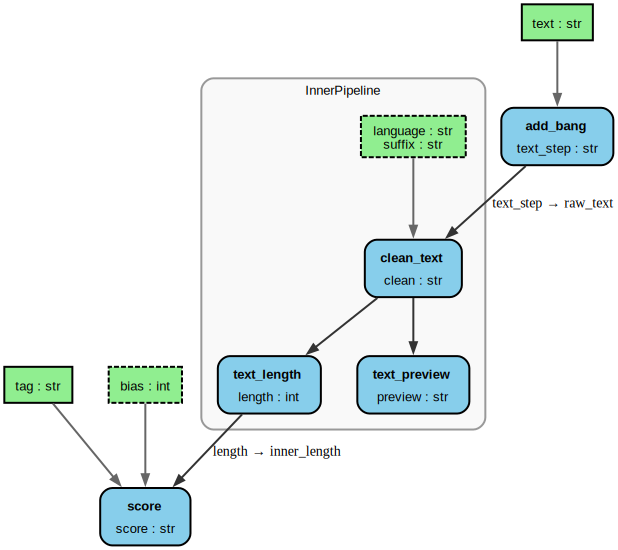

In [12]:
# Visualize the fixed pipeline
outer_fixed.visualize(depth=2, interactive=False)

In [13]:
def summarize_view(view):
    print("Nodes:")
    for n in view.get("nodes", []):
        print(
            f"- {n.get('label'):<14} type={n.get('node_type'):<8} "
            f"expanded={n.get('is_expanded')} "
            f"root_args={n.get('root_args')} "
            f"unfulfilled={n.get('unfulfilled_args')} "
            f"bound={n.get('bound_inputs')} "
            f"outputs={n.get('output_name') or n.get('output_names')} "
            f"inner_bound={n.get('inner_bound_inputs')}"
        )
    print("Edges:", [(e["source"], e["target"]) for e in view.get("edges", [])])


def find_node_id(view, label):
    for n in view.get("nodes", []):
        if n.get("label") == label:
            return n["id"]
    raise ValueError(f"Node {label!r} not found")


In [14]:
handler = UIHandler(outer, depth=1)
view1 = handler.get_view_data()
summarize_view(view1)


Nodes:
- add_bang       type=STANDARD expanded=False root_args=['text'] unfulfilled=None bound=None outputs=text_step inner_bound=None
- InnerPipeline  type=PIPELINE expanded=False root_args=['text_step'] unfulfilled=['text_step'] bound=['language', 'suffix'] outputs=['inner_length', 'inner_preview'] inner_bound=['language', 'suffix']
- score          type=STANDARD expanded=False root_args=['inner_length', 'tag', 'bias'] unfulfilled=None bound=None outputs=score inner_bound=None
Edges: [('4532269376', '4533657552'), ('input_text', '4532269376'), ('4533657552', '4533657024'), ('input_tag', '4533657024'), ('input_bias', '4533657024')]


In [15]:
inner_id = find_node_id(view1, "InnerPipeline")
update = handler.handle_event({"type": "expand", "node_id": inner_id})
print(
    "Expand delta:",
    len(update.added_nodes),
    "nodes added,",
    len(update.removed_nodes),
    "nodes removed",
)
view_expanded = handler.get_view_data()
summarize_view(view_expanded)


Expand delta: 3 nodes added, 0 nodes removed
Nodes:
- add_bang       type=STANDARD expanded=False root_args=['text'] unfulfilled=None bound=None outputs=text_step inner_bound=None
- InnerPipeline  type=PIPELINE expanded=True root_args=['text_step'] unfulfilled=['text_step'] bound=['language', 'suffix'] outputs=['inner_length', 'inner_preview'] inner_bound=['language', 'suffix']
- clean_text     type=STANDARD expanded=False root_args=['raw_text', 'suffix', 'language'] unfulfilled=None bound=None outputs=clean inner_bound=None
- text_length    type=STANDARD expanded=False root_args=['clean'] unfulfilled=None bound=None outputs=length inner_bound=None
- text_preview   type=STANDARD expanded=False root_args=['clean'] unfulfilled=None bound=None outputs=preview inner_bound=None
- score          type=STANDARD expanded=False root_args=['inner_length', 'tag', 'bias'] unfulfilled=None bound=None outputs=score inner_bound=None
Edges: [('4532269376', '4533657552__4441841760'), ('input_suffix', '4

In [16]:
handler2 = UIHandler(outer, depth=2)
view2 = handler2.get_view_data()
summarize_view(view2)

inner_id2 = find_node_id(view2, "InnerPipeline")
update2 = handler2.handle_event({"type": "collapse", "node_id": inner_id2})
print(
    "Collapse delta:",
    len(update2.added_nodes),
    "nodes added,",
    len(update2.removed_nodes),
    "nodes removed",
)
summarize_view(handler2.get_view_data())


Nodes:
- add_bang       type=STANDARD expanded=False root_args=['text'] unfulfilled=None bound=None outputs=text_step inner_bound=None
- InnerPipeline  type=PIPELINE expanded=True root_args=['text_step'] unfulfilled=['text_step'] bound=['language', 'suffix'] outputs=['inner_length', 'inner_preview'] inner_bound=['language', 'suffix']
- clean_text     type=STANDARD expanded=False root_args=['raw_text', 'suffix', 'language'] unfulfilled=None bound=None outputs=clean inner_bound=None
- text_length    type=STANDARD expanded=False root_args=['clean'] unfulfilled=None bound=None outputs=length inner_bound=None
- text_preview   type=STANDARD expanded=False root_args=['clean'] unfulfilled=None bound=None outputs=preview inner_bound=None
- score          type=STANDARD expanded=False root_args=['inner_length', 'tag', 'bias'] unfulfilled=None bound=None outputs=score inner_bound=None
Edges: [('4532269376', '4533657552__4441841760'), ('input_suffix', '4533657552__4441841760'), ('input_language', '

In [17]:
full = handler2.get_full_graph_with_state(include_events=True)
print("Keys:", list(full.keys()))
print("Sample nodes entry:")
pprint(full["nodes"][:2])

out_path = Path("outputs/ui_handler_full.json")
out_path.parent.mkdir(parents=True, exist_ok=True)
out_path.write_text(json.dumps(full, indent=2))
print("Saved", out_path)


Keys: ['nodes', 'edges', 'levels', 'input_levels', 'grouped_inputs', 'applied_options', 'render_nodes', 'render_edges', 'event_index']
Sample nodes entry:
[{'function_name': 'add_bang',
  'id': '4532269376',
  'inputs': [{'default_value': None,
              'is_bound': False,
              'is_fulfilled_by_sibling': False,
              'name': 'text',
              'type_hint': 'str'}],
  'is_expanded': False,
  'label': 'add_bang',
  'level_id': 'root',
  'node_type': 'STANDARD',
  'output_name': 'text_step',
  'output_names': ['text_step'],
  'root_args': ['text']},
 {'bound_inputs': ['language', 'suffix'],
  'function_name': 'InnerPipeline',
  'id': '4533657552',
  'inner_bound_inputs': ['language', 'suffix'],
  'inner_root_args': ['language', 'raw_text', 'suffix'],
  'input_mapping': {'text_step': 'raw_text'},
  'inputs': [{'default_value': None,
              'is_bound': False,
              'is_fulfilled_by_sibling': False,
              'name': 'text_step',
              'type

In [18]:
# Generate a combined HTML showing Graphviz (static) + interactive React
handler_html = UIHandler(outer, depth=2)
graph_static = handler_html.get_view_data()
graph_interactive = handler_html.get_full_graph_with_state(include_events=True)

# gv_html = GraphvizEngine().render(graph_static, return_type="html")
react_html = generate_widget_html(transform_to_react_flow(graph_interactive))

combined = f'''<!DOCTYPE html>
<html><head><meta charset="UTF-8"><title>UI Handler Demo</title></head>
<body style="background:#0b1120;color:#e2e8f0;font-family:sans-serif;">
<h3>Interactive (React)</h3>
<iframe srcdoc="{react_html.replace('"', "&quot;")}" style="width:100%;height:640px;border:1px solid #334155;border-radius:8px;"></iframe>
</body></html>
'''

html_path = Path("outputs/ui_handler_demo.html")
html_path.write_text(combined)
print("Wrote", html_path)
HTML(combined)


Wrote outputs/ui_handler_demo.html


# ✅ Input Node Placement Fix

The bug where input nodes appeared outside their correct container has been fixed!

Before: When visualizing at depth=2, inputs consumed only by nested nodes appeared at root.
After: Inputs now correctly appear inside the nested pipeline container.

In [19]:
# Verify the fix: check input levels at depth=2
handler_depth2 = UIHandler(outer, depth=2, group_inputs=False)
view_depth2 = handler_depth2.get_view_data()

print("=== Input nodes at depth=2 (expanded) ===")
input_nodes = [n for n in view_depth2["render_nodes"] if n.get("node_type") == "INPUT"]
for inp in input_nodes:
    param = inp["id"].replace("input_", "")
    level = inp.get("level_id")
    if "nested" in level:
        print(f"✅ {param:15} → {level} (INSIDE nested pipeline)")
    else:
        print(f"❌ {param:15} → {level} (at root - should be inside!)")

print("\n=== Visualization at depth=2 ===")
print(
    "All inputs should appear INSIDE the InnerPipeline container, not floating at root"
)

=== Input nodes at depth=2 (expanded) ===
✅ suffix          → root__nested_4533657552 (INSIDE nested pipeline)
✅ language        → root__nested_4533657552 (INSIDE nested pipeline)
❌ text            → root (at root - should be inside!)
❌ tag             → root (at root - should be inside!)
❌ bias            → root (at root - should be inside!)

=== Visualization at depth=2 ===
All inputs should appear INSIDE the InnerPipeline container, not floating at root


In [ ]:
outer.visualize(depth=2, interactive=False)